In [95]:
import lxml
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os, os.path
from lxml import etree as ET

### Importing the csv containing the data for BambergMsc30. The csv is structured in the following way :
  > * lemma_id = the indexing id corresponding to the page, line and line order in Kei's edition (eg. p447_l05_o02)
  > * lemma
 > * gloss_type = typology according to Cinato(2015), (eg. S23 for definition, S22 for synonyms, etc.)
 > * gloss_form = relative size (eg. F1 for sign, F2 for word, F3 for syntagm or agregation of words, F4 for phrase and F5 for paragraph)
> * same for marginal_notes

In [96]:
# Define the namespace mapping
ns = {"tei": "http://www.tei-c.org/ns/1.0", "xml": "http://www.w3.org/XML/1998/namespace"}

# Parse the XML file using ElementTree
tree_B = etree.parse("/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/BambergMsc30/XML-XSLT/BambergMsc30_edition_documentaire.xml")
root_B = tree_B.getroot()

# Create empty lists to store the extracted information
metadata_B = []

# Iterate through all <seg type="lemma"> elements and extract their xml:id and lemma values
lemmas_B = root_B.findall(".//tei:seg", namespaces=ns)

for i, lemma in enumerate(lemmas_B):
    lemma_id = lemma.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
    lemma_text = lemma.text
    
    # Find the previous pb element
    folio = None
    for sibling in lemma.itersiblings(preceding=True):
        if sibling.tag == "{http://www.tei-c.org/ns/1.0}pb":
            folio = sibling.attrib.get("n")
            break
    
    # Find the corresponding gloss elements
    glosses = root_B.findall(".//tei:gloss[@target='#" + lemma_id + "']", namespaces=ns)
    
    if glosses:
        for gloss in glosses:
            gloss_id = gloss.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            gloss_type = gloss.attrib.get("ana")
            gloss_form = gloss.attrib.get("style")
            gloss_text = gloss.text.strip()

            # Find the previous sibling element
            previous_sibling = gloss.getprevious()
            while previous_sibling is not None and previous_sibling.tag != "{http://www.tei-c.org/ns/1.0}lb":
                previous_sibling = previous_sibling.getprevious()

            # Retrieve the lb type attribute
            lb_type = None
            if previous_sibling is not None:
                lb_type = previous_sibling.attrib.get("type")

            # Determine the nature based on the lb type
            nature = "shorthand" if lb_type == "tironian" else "normal"

            
            metadata_B.append((folio, lemma_id, lemma_text, gloss_id, gloss_text, gloss_type, gloss_form, nature))
    else:
        # If there are no matching glosses, append None for the gloss columns
        metadata_B.append((folio, lemma_id, lemma_text, None, None, None, None, None))

    # Find all <fw type="marginal_note"> elements that correspond to this lemma
    marginal_notes = root_B.findall(".//tei:fw[@corresp='#" + lemma_id + "']", namespaces=ns)
    
    if marginal_notes:
        # If there is at least one matching marginal note, loop through them and append to metadata
        # ...
        for marginal_note in marginal_notes:
            marginal_note_id = marginal_note.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            marginal_note_type = marginal_note.attrib.get("ana")
            marginal_note_style = marginal_note.attrib.get("style")

            # Append the marginal note to the last row of metadata (which corresponds to the current lemma)
        metadata_B[-1] = metadata_B[-1][:8] + (marginal_note_id, marginal_note_type, marginal_note_style)

Bamberg = pd.DataFrame(metadata_B, columns=["folio", "lemma_id", "lemma", "gloss_id", "gloss", "gloss_type", "gloss_form", "nature", "marginal_note_id", "marginal_note_type", "marginal_note_form"])
Bamberg.to_csv('/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/comparative_mss_analysis/metadata_csv/Bamberg.csv', index=False)
Bamberg


,folio,lemma_id,lemma,gloss_id,gloss,gloss_type,gloss_form,nature,marginal_note_id,marginal_note_type,marginal_note_form
0,71r,p447_l01_o00,EVTICII,None,None,None,None,None,p447_l01_o00_a,S54,F5
1,71r,p447_l05_o02,SEMPER,p447_l05_o02_a,ꝓ sepe,S22,F2,normal,None,None,None
2,71r,p447_l05_o04,QVĘSTIONES,p447_l05_o04_a,ꝓ positiones,S22,F2,normal,None,None,None
3,71r,p447_l05_o05,DOCTORIBVS,p447_l05_o05_a,PRAECEP ͭ ͦ ͬ ͥᵇ ͧ ᷤ,S22,F2,shorthand,None,None,None
4,71r,p447_l05_o06,AVDITORVM,p447_l05_o06_a,discipulorũ,S22,F2,normal,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2026,85v,f85v_l01_o04,ingeniosus,f85v_l01_o04_a,bonꝰ textor +++,S23,F4,shorthand,None,None,None
2027,85v,f85v_l07_o16,ΕΚΡΥΨΑ,f85v_l07_o16_a,nu psi,S221,F1,normal,None,None,None
2028,85v,f85v_l08_o02,ΕΛΥΦΟ,f85v_l08_o02_a,iungo,S221,F2,normal,None,None,None
2029,85v,f85v_l08_o03,ΕΛΥΦΑ,f85v_l08_o03_a,iunxi,S221,F2,normal,None,None,None


In [97]:
# Create counters for lb types
lb_counts = {
    'tironian': 0,
    'interlinear': 0,
    'principal': 0
}

# Create counters for lb types inside and outside fw type="marginal_note"
lb_counts_inside_marginal = {
    'tironian': 0,
    'interlinear': 0,
    'principal': 0
}
lb_counts_outside_marginal = {
    'tironian': 0,
    'interlinear': 0,
    'principal': 0
}

# Iterate through all <lb> elements and count their types
lbs = root_B.findall(".//tei:lb", namespaces=ns)
for lb in lbs:
    lb_type = lb.attrib.get("type")
    if lb_type in lb_counts:
        lb_counts[lb_type] += 1
        
    # Check if lb is inside or outside fw type="marginal_note"
    parent_fw = lb.getparent()
    while parent_fw is not None and parent_fw.tag != "{http://www.tei-c.org/ns/1.0}fw":
        parent_fw = parent_fw.getparent()
        
    if parent_fw is not None:
        if lb_type in lb_counts_inside_marginal:
            lb_counts_inside_marginal[lb_type] += 1
    else:
        if lb_type in lb_counts_outside_marginal:
            lb_counts_outside_marginal[lb_type] += 1

# Print the lb counts
print("LB Counts:")
print(lb_counts)

# Print the lb counts inside fw type="marginal_note"
print("LB Counts Inside Marginal Note:")
print(lb_counts_inside_marginal)

# Print the lb counts outside fw type="marginal_note"
print("LB Counts Outside Marginal Note:")
print(lb_counts_outside_marginal)

LB Counts:
{'tironian': 286, 'interlinear': 1498, 'principal': 1725}
LB Counts Inside Marginal Note:
{'tironian': 13, 'interlinear': 0, 'principal': 865}
LB Counts Outside Marginal Note:
{'tironian': 273, 'interlinear': 1498, 'principal': 860}


## We apply .description() to get a quick first analytics of the dataframe :
> * **30 glossed folios** with 75r being the most mentionned (141 lemmas glossed)
> * **2031 lemmas** with 1788 unique ones (186 being repeated - not uncommon since Eutyches uses the same examples accross his work eg. we have "positionis" glossed 5 times)
> * **1764 glosses** with approx 382 repeated ones - but we do have 103 "+" signs that denote shorthand that I cound't decipher or didn't have time to do so
> * **28 unique typologies** with **S22 being the most frequent** counting 1190 occurences 
> * glosses all across 5 sizes/forms with **F2 being the most frequent** (1229 occurences)
> * **570 marginal notes** where **S63 (title, mise en exergue) is the most common typology (467 occurences) and F2 (word) the most common relative size (383 occurences)**
> * Finally, in terms of nature of gloss annotation, we have **1493 "normal" lettered annotations and 270 shorthand notes**, which is a significant number of tironian notes for glosses

In [98]:
description = Bamberg.describe()
description

,folio,lemma_id,lemma,gloss_id,gloss,gloss_type,gloss_form,nature,marginal_note_id,marginal_note_type,marginal_note_form
count,2031,2031,2031,1764,1764,1764,1764,1764,570,570,570
unique,30,2031,1788,1764,1377,28,5,2,570,22,4
top,75r,p447_l01_o00,eo,p447_l05_o02_a,+,S22,F2,normal,p447_l01_o00_a,S63,F2
freq,141,1,5,1,107,1240,1233,1494,1,467,385


In [99]:
# Create the new DataFrame with the desired condition
unique_lemmas_Bamberg = Bamberg[Bamberg['lemma_id'].str.startswith('f')]

# Print the filtered DataFrame
len(unique_lemmas_Bamberg) #33

unique_lemmas_Bamberg

,folio,lemma_id,lemma,gloss_id,gloss,gloss_type,gloss_form,nature,marginal_note_id,marginal_note_type,marginal_note_form
163,71v,f74r_l17_o12,scabeo,f74r_l17_o12_a,scalpo,S22,F2,normal,None,None,None
164,71v,f74r_l18_o01,arceo,f74r_l18_o01_a,ꝓhibeo,S22,F2,normal,None,None,None
190,71v,f71v_l24_o05,calceo,None,None,None,None,None,f71v_l24_o05_a,S54,F4
315,72r,f75r_l06_o23,quatio,f75r_l06_o23_a,moueo,S22,F2,normal,None,None,None
423,73r,f76v_l22_o04,obsono,f76v_l22_o04_a,c̃rtasono ++,S22,F3,normal,None,None,None
427,73r,f73r_l10_o10,Alo,f73r_l10_o10_a,nutrio nutritor,S22,F2,normal,None,None,None
430,73r,f73r_l11_o01,Stupeo,f73r_l11_o01_a,admiror,S22,F2,normal,None,None,None
431,73r,f73r_l11_o02,Stupor,f73r_l11_o02_a,admiratio,S22,F2,normal,None,None,None
494,73r,f73r_l29_o02,carax,f73r_l29_o02_a,ñ habens,S23,F3,normal,f73r_l29_o02_b,S63,F2
628,74r,f74r_l10_o19-20,in .ibilis.,None,None,None,None,None,f74r_l10_o19-20_a,S63,F3


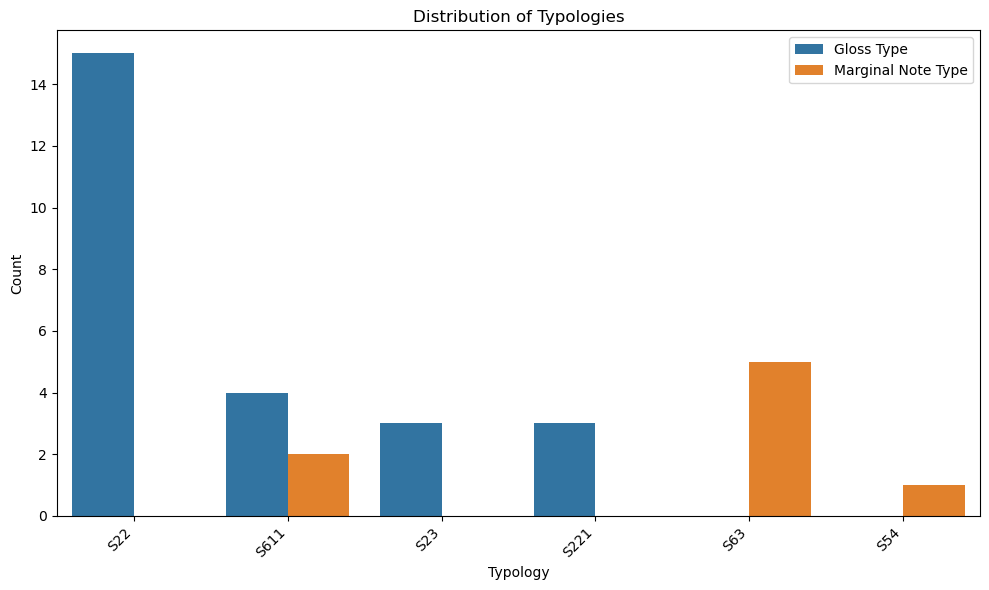

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each typology in the 'gloss_type' column
gloss_type_counts = unique_lemmas_Bamberg['gloss_type'].value_counts()

# Count the occurrences of each typology in the 'marginal_note_type' column
marginal_note_type_counts = unique_lemmas_Bamberg['marginal_note_type'].value_counts()

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Combine the two typology counts into a single DataFrame
typology_counts = pd.concat([gloss_type_counts, marginal_note_type_counts], axis=1)

# Reset the index and rename the columns
typology_counts = typology_counts.reset_index()
typology_counts.columns = ['Typology', 'Gloss Type', 'Marginal Note Type']

# Melt the DataFrame to convert it into long format
typology_counts = typology_counts.melt(id_vars='Typology', var_name='Column', value_name='Count')

# Filter out rows where the count is zero
typology_counts = typology_counts[typology_counts['Count'] > 0]

# Plot the stacked bar plot
sns.barplot(data=typology_counts, x='Typology', y='Count', hue='Column')

# Set the x-axis label, y-axis label, and title
ax.set_xlabel('Typology')
ax.set_ylabel('Count')
ax.set_title('Distribution of Typologies')

# Rotate x-axis labels if needed
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the legend
ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## I want to use later the tironian notes in comparison with the glosses from Lat7499 to compare how many lemmas are glossed with a tironian note instead of latin letters but for now I just want to see the percentage of tironian glosses in Bamberg (we should not forget that marginal notes are also sometimes composed of shorthand but since it's not the total annotation composed of shorthand it's more difficult to quantify )

In [101]:
# Count the occurrences of each unique value in the "nature" column
nature_counts = Bamberg['nature'].value_counts()

# Calculate the percentage of "normal" annotations
normal_percentage = (nature_counts['normal'] / len(Bamberg['nature'])) * 100

# Calculate the percentage of "shorthand" annotations
shorthand_percentage = (nature_counts['shorthand'] / len(Bamberg['nature'])) * 100

# Print the percentages
print("Percentage of 'normal' annotations:", normal_percentage)
print("Percentage of 'shorthand' annotations:", shorthand_percentage)


Percentage of 'normal' annotations: 73.55982274741507
Percentage of 'shorthand' annotations: 13.293943870014772


## Let's explore the diversity of the typologies and their relative proportion/size across the BambergMsc30 dataset - We see that glosses are more diverse in typology and we have a lot of marginal categories and which categories are more privileged in the manuscirpt.

In [102]:
import plotly

In [103]:
import plotly.graph_objects as go

# Count the occurrences of each unique typology in "marginal_type" column
marginal_type_counts = Bamberg['marginal_note_type'].value_counts()

# Count the occurrences of each unique typology in "gloss_type" column
gloss_type_counts = Bamberg['gloss_type'].value_counts()

# Create a DataFrame for the bar chart
marginal_bar_data = pd.DataFrame({'typology': marginal_type_counts.index, 'count': marginal_type_counts.values})
gloss_bar_data = pd.DataFrame({'typology': gloss_type_counts.index, 'count': gloss_type_counts.values})

# Create the bar chart figure using plotly
fig = go.Figure()

# Add trace for marginal_type
fig.add_trace(go.Bar(
    x=marginal_bar_data['count'],
    y=marginal_bar_data['typology'],
    orientation='h',
    name='Marginal Type',
    marker=dict(
        color=['blue' for count in marginal_bar_data['count']],  # Color bars 
    )
))

# Add trace for gloss_type
fig.add_trace(go.Bar(
    x=gloss_bar_data['count'],
    y=gloss_bar_data['typology'],
    orientation='h',
    name='Gloss Type',
    marker=dict(
        color=['green' for count in gloss_bar_data['count']],  # Color bars
    )
))

# Set the title for the bar chart
fig.update_layout(title='Distribution of Typologies across Marginal notes and Glosses with logarithmic scale')

# Set x-axis scale to logarithmic
fig.update_xaxes(type='log')

# Add vertical lines at x=5, 10, and 100
fig.add_shape(
    type='line',
    x0=20, x1=20, y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color='black', width=1, dash='dash')
)

fig.add_shape(
    type='line',
    x0=40, x1=40, y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color='black', width=1, dash='dash')
)

fig.add_shape(
    type='line',
    x0=100, x1=100, y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color='black', width=1, dash='dash')
)

# Show the bar chart
fig.show()


### Let's explore relative proportion of typologies/sizes across the manuscript glosses and marginalia. That way we can understand how lengthy or not a specific typology can be

In [104]:
gloss_relative_proportions = Bamberg.groupby('gloss_type')['gloss_form'].value_counts(normalize=True).reset_index(name='proportion')
marginalia_relative_proportions = Bamberg.groupby('marginal_note_type')['marginal_note_form'].value_counts(normalize=True).reset_index(name='proportion')


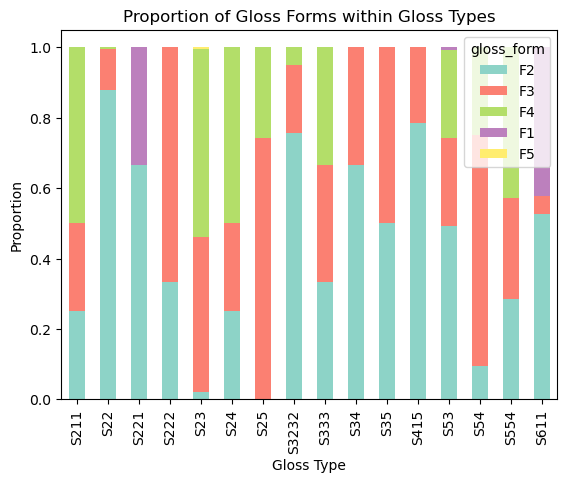

In [105]:

# Filter the DataFrame for typologies with multiple options and meeting the threshold
multiple_options = gloss_relative_proportions.groupby('gloss_type').filter(lambda x: len(x) > 1 and (x['proportion'] > 0.100).any())

# Pivot the DataFrame to have gloss forms as columns
pivot_table = multiple_options.pivot(index='gloss_type', columns='gloss_form', values='proportion')

# Sort the columns based on their total proportions
pivot_table = pivot_table[pivot_table.sum().sort_values(ascending=False).index]

# Plot the stacked bar plot
pivot_table.plot(kind='bar', stacked=True, cmap='Set3')

# Set the labels and title
plt.xlabel('Gloss Type')
plt.ylabel('Proportion')
plt.title('Proportion of Gloss Forms within Gloss Types')

# Display the plot
plt.savefig('graphs/proportion_typologies_forms_glosses.png')

plt.show()



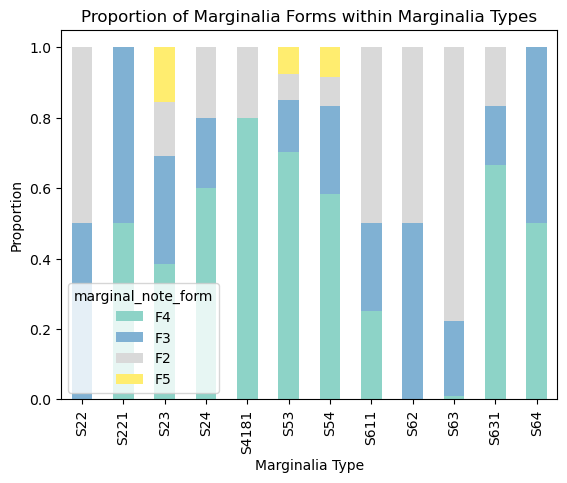

In [106]:

# Filter the DataFrame for typologies with multiple options and meeting the threshold
marg_multiple_options = marginalia_relative_proportions.groupby('marginal_note_type').filter(lambda x: len(x) > 1 and (x['proportion'] > 0.000).any())

# Pivot the DataFrame to have gloss forms as columns
pivot_table = marg_multiple_options.pivot(index='marginal_note_type', columns='marginal_note_form', values='proportion')

# Sort the columns based on their total proportions
pivot_table = pivot_table[pivot_table.sum().sort_values(ascending=False).index]

# Plot the stacked bar plot
pivot_table.plot(kind='bar', stacked=True, cmap='Set3')

# Set the labels and title
plt.xlabel('Marginalia Type')
plt.ylabel('Proportion')
plt.title('Proportion of Marginalia Forms within Marginalia Types')

plt.savefig('graphs/proportion_typologies_forms_marginalia.png')

plt.show()


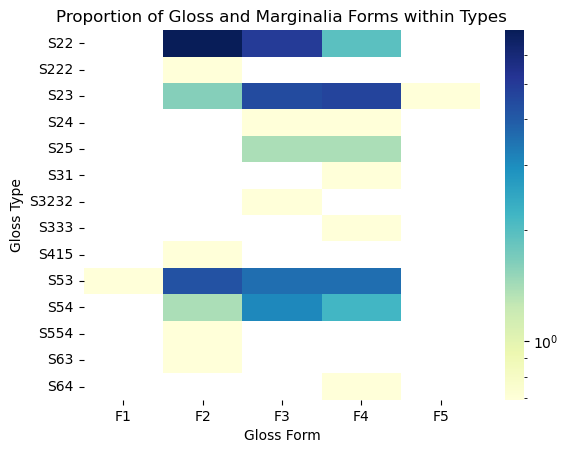

In [107]:
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm


typologies_of_interest = ['S22', 'S23', 'S53', 'S54', 'S63', 'S631', 'S64']  # Specify the typologies of interest

filtered_df = Bamberg[Bamberg['gloss_type'].isin(typologies_of_interest) | Bamberg['marginal_note_type'].isin(typologies_of_interest)]

cross_tab = pd.crosstab(filtered_df['gloss_type'], [filtered_df['gloss_form']])

# Calculate the logarithm of the counts for scaling
log_cross_tab = np.log1p(cross_tab)

# Plot the heatmap with logarithmic scaling
sns.heatmap(data=log_cross_tab, cmap='YlGnBu',norm=LogNorm())

# Set the labels and title
plt.xlabel('Gloss Form')
plt.ylabel('Gloss Type')
plt.title('Proportion of Gloss and Marginalia Forms within Types')

# Display the plot
plt.savefig('graphs/proportion_typologies_forms_glosses_heatmap.png')
plt.show()


In [108]:
#First, let's explore the percentage of glosses and marginal_annotations in the total annotations
# Calculate the total number of annotations
total_annotations = len(Bamberg)

# Calculate the number of glosses
num_glosses = Bamberg['gloss'].count()

# Calculate the number of marginal notes
num_marginal_notes = Bamberg['marginal_note_type'].count()

# Calculate the percentage of glosses
percentage_glosses = (num_glosses / total_annotations) * 100

# Calculate the percentage of marginal notes
percentage_marginal_notes = (num_marginal_notes / total_annotations) * 100

# Print the results
print(f"Percentage of glosses: {percentage_glosses:.2f}%")
print(f"Percentage of marginal notes: {percentage_marginal_notes:.2f}%")

Percentage of glosses: 86.85%
Percentage of marginal notes: 28.06%


In [109]:
import re
# Open the text file in read mode
with open('/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/BambergMsc30/XML-XSLT/out/BambergMsc30_txt.txt', 'r') as file:
    # Read the contents of the file
    text = file.read()

# Perform modifications to the text
modified_text = re.sub(r'\s+', ' ', text)

# Open the same file or a new file in write mode
with open('/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/BambergMsc30/XML-XSLT/out/Bamberg_txt_singlespace.txt', 'w') as file:
    # Write the modified text to the file
    file.write(modified_text)

# Display a message indicating the process is completed
print("File manipulation completed.")

File manipulation completed.


### We are going to count the words per folio in the main txt, and then the amount of lemmas, to determine the percentage of text that is being annotated per page.


In [110]:

# Open the text file in read mode
with open('/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/BambergMsc30/XML-XSLT/out/Bamberg_txt_singlespace.txt', 'r') as file:
    # Read the contents of the file
    text = file.read()

# Find folio milestones and count words between them
folio_pattern = r'folio=(\d{2}[a-zA-Z])'
matches = re.findall(folio_pattern, text)

word_counts = []
for i in range(len(matches)):
    start_index = text.index(matches[i]) + len(matches[i])
    if i == len(matches) - 1:
        end_index = len(text)
    else:
        end_index = text.index(matches[i + 1])
    segment = text[start_index:end_index].strip()
    words = re.findall(r'\b\w+\b', segment)
    word_count = len(words)
    word_counts.append((matches[i], word_count))

# Create a dataframe with the word counts
Bamberg_words_perfolio = pd.DataFrame(word_counts, columns=["folio", "word_counts"])

# Print the dataframe
#Bamberg_words_perfolio

In [111]:
Bamberg_lemma_perfolio = Bamberg.groupby('folio')['lemma_id'].count().reset_index()
Bamberg_lemma_perfolio = Bamberg_lemma_perfolio.rename(columns={'lemma_id': 'lemma_counts'})

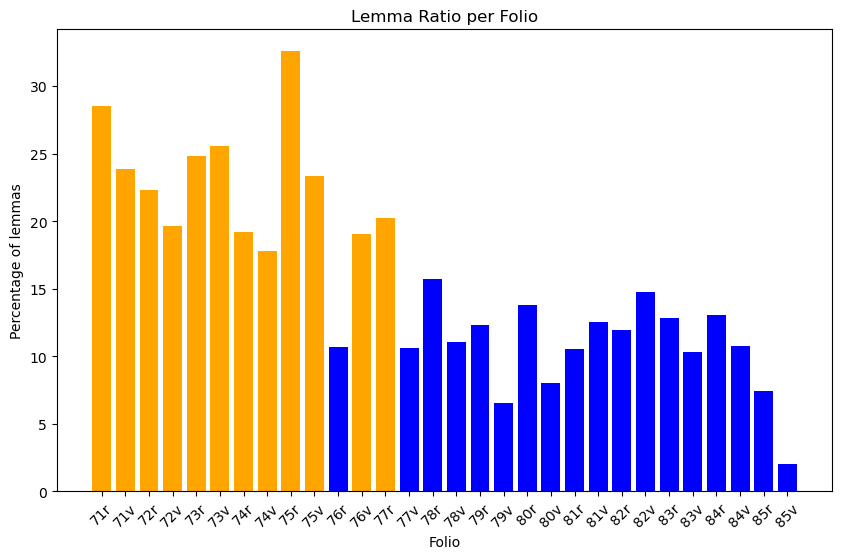

In [112]:
import numpy as np

Bamberg_ratiooflemma_perfolio = pd.merge(Bamberg_words_perfolio, Bamberg_lemma_perfolio, on='folio')
# Calculate the lemma ratio as a percentage
Bamberg_ratiooflemma_perfolio['lemma_ratio'] = (Bamberg_ratiooflemma_perfolio['lemma_counts'] / Bamberg_ratiooflemma_perfolio['word_counts']) * 100
# Calculate the average lemma ratio
average_lemma_ratio = Bamberg_ratiooflemma_perfolio['lemma_ratio'].mean()



# Create a list of colors for the bars
colors = ['orange' if ratio > average_lemma_ratio else 'blue' for ratio in Bamberg_ratiooflemma_perfolio['lemma_ratio']]

# Plotting the lemma ratio for each folio
plt.figure(figsize=(10, 6))
plt.bar(Bamberg_ratiooflemma_perfolio['folio'], Bamberg_ratiooflemma_perfolio['lemma_ratio'], color=colors)
plt.xlabel('Folio')
plt.ylabel('Percentage of lemmas')
plt.title('Lemma Ratio per Folio')

plt.xticks(rotation=45)

plt.savefig('graphs/lemma_ratio_per_folio.png')


plt.show()

/var/folders/ps/09_p7rl14y11qx52mcmvrr_w0000gq/T/ipykernel_37056/1611358596.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



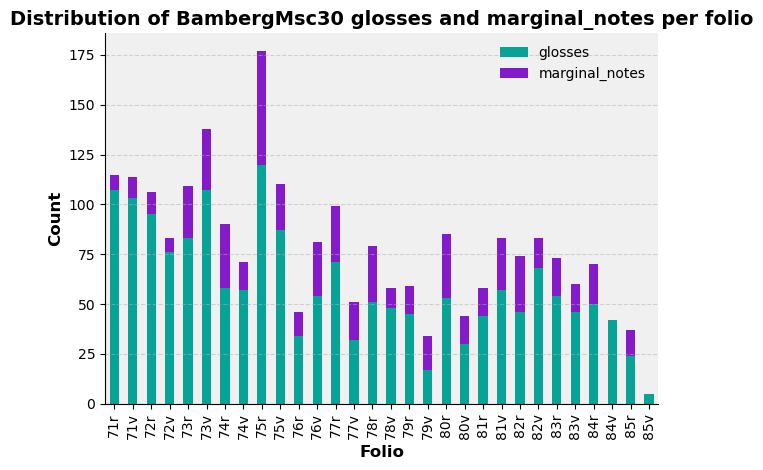

In [113]:
# Group the data by 'folio' and count the occurrences of 'gloss_id' and 'marginal_note_id'
grouped_Bamberg = Bamberg.groupby('folio')['gloss', 'marginal_note_id'].count()

# Set a custom color palette
colors = ['#06A396', '#851ACB']

# Plot the stacked bar chart
ax = grouped_Bamberg.plot(kind='bar', stacked=True, color=colors)

# Set the labels and title
plt.xlabel('Folio', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Distribution of BambergMsc30 glosses and marginal_notes per folio', fontsize=14, fontweight='bold')

# Customize tick labels rotation and font size
plt.xticks(rotation=90, fontsize=10)

# Customize legend
plt.legend(['glosses', 'marginal_notes'], frameon=False)

# Set the figure background color
plt.gca().set_facecolor('#F0F0F0')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust the layout for better spacing
plt.tight_layout()

plt.savefig('graphs/distribution_glosses_marginal_folio.png')


# Display the plot
plt.show()

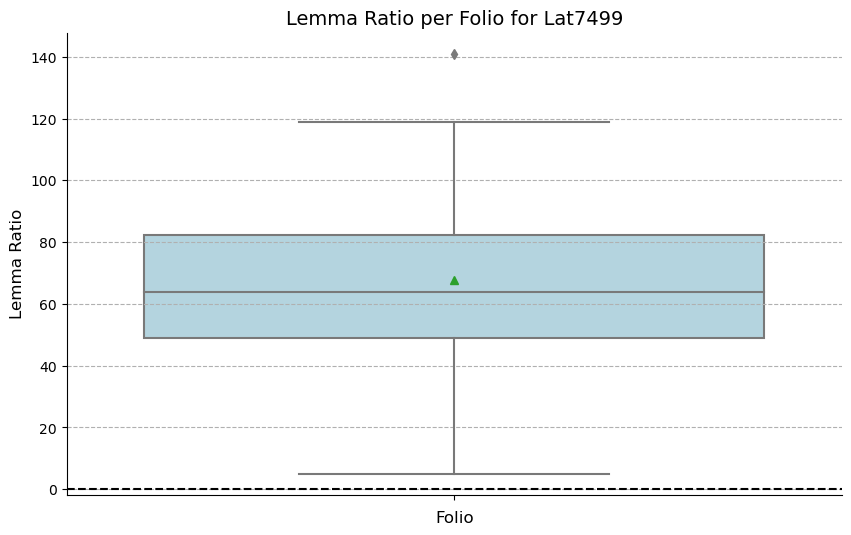

In [114]:
import seaborn as sns


# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot with mean and show outliers
sns.boxplot(data=Bamberg_ratiooflemma_perfolio, y='lemma_counts', showmeans=True, showfliers=True, color='lightblue')

# Set the axes labels and title
plt.xlabel('Folio', fontsize=12)
plt.ylabel('Lemma Ratio', fontsize=12)
plt.title('Lemma Ratio per Folio for Lat7499', fontsize=14)

# Set the font size of the axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove the top and right spines
sns.despine()

# Add a grid
plt.grid(axis='y', linestyle='--')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--')

# Save the plot
plt.savefig('graphs/boxplot_lemma_ratio_per_folio.png', dpi=300)

# Display the plot
plt.show()

/var/folders/ps/09_p7rl14y11qx52mcmvrr_w0000gq/T/ipykernel_37056/1093903021.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



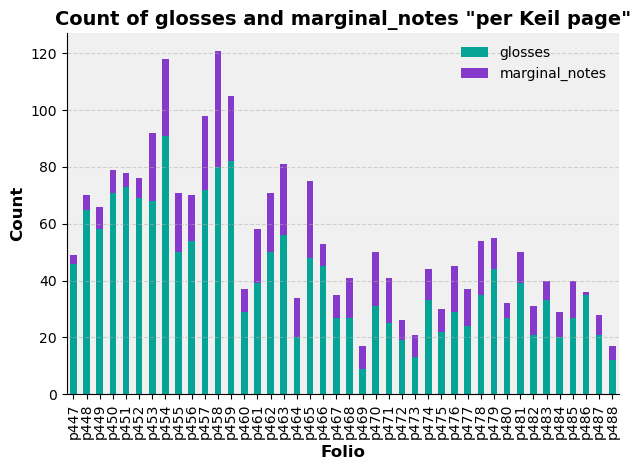

In [115]:
# Group the data by 'folio' and count the occurrences of 'gloss_id' and 'marginal_note_id'
Bamberg['page'] = Bamberg['lemma_id'].str.extract(r'(p\d+)')
Bamberg_diffusion_Keil = Bamberg.groupby('page')['gloss', 'marginal_note_id'].count()

# Set a custom color palette
colors = ['#05A496', '#853ACB']

# Plot the stacked bar chart
ax = Bamberg_diffusion_Keil.plot(kind='bar', stacked=True, color=colors)

# Set the labels and title
plt.xlabel('Folio', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Count of glosses and marginal_notes "per Keil page"', fontsize=14, fontweight='bold')

# Customize tick labels rotation and font size
plt.xticks(rotation=90, fontsize=10)

# Customize legend
plt.legend(['glosses', 'marginal_notes'], frameon=False)

# Set the figure background color
plt.gca().set_facecolor('#F0F0F0')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust the layout for better spacing
plt.tight_layout()

plt.savefig('graphs/distribution_glosses_marginal_Keil.png')


# Display the plot
plt.show()

In [116]:
Bamberg_diffusion_Keil=Bamberg_diffusion_Keil.reset_index()
Bamberg_diffusion_Keil

,page,gloss,marginal_note_id
0,p447,46,3
1,p448,65,5
2,p449,58,8
3,p450,71,8
4,p451,73,5
5,p452,69,7
6,p453,68,24
7,p454,91,27
8,p455,50,21
9,p456,54,16


In [117]:
Bamberg_diffusion_Keil.to_csv('/Users/vlachou/Desktop/ENC/MEMOIRE/Eutyches/comparative_mss_analysis/diffusion_csv/diffusion_Bamberg_annotations_Keil.csv', encoding='utf-8')
